<a href="https://colab.research.google.com/github/ldselvera/Fraud_Detection_Deep_Learning/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam

from keras import regularizers, optimizers
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv1D, Dense, Flatten, Activation, UpSampling1D, MaxPooling1D, ZeroPadding1D
from keras.layers import Flatten, Dropout, BatchNormalization, MaxPool1D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn import datasets, decomposition, preprocessing

from mpl_toolkits.mplot3d import Axes3D

print(tf.__version__)

2.4.1


## Dataset

In [2]:
#import dataset from csv

#Modify with your own path
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/fraud/creditcard.csv")

In [3]:
#preview of the data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### Check for missing values (Null/NaN)

In [5]:
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Imbalanced data

In [6]:
# Number of instances per class 
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


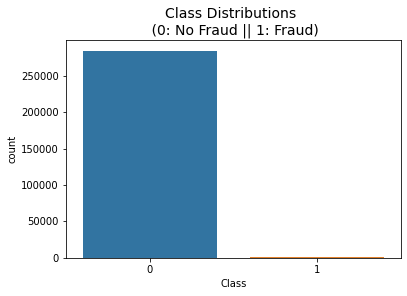

In [8]:
sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

In [9]:
def show_pca_df(df):
	x = df[df.columns[1:30]].to_numpy()
	y = df[df.columns[30]].to_numpy()

	x = preprocessing.MinMaxScaler().fit_transform(x)
	pca = decomposition.PCA(n_components=3)
	pca_result = pca.fit_transform(x)
	print(pca.explained_variance_ratio_)

	pca_df = pd.DataFrame(data=pca_result, columns=['pc_1', 'pc_2', 'pc_3'])
	pca_df = pd.concat([pca_df, pd.DataFrame({'label': y})], axis=1)

	ax = Axes3D(plt.figure(figsize=(8, 8)))
	ax.scatter(xs=pca_df['pc_1'], ys=pca_df['pc_2'], zs=pca_df['pc_3'], c=pca_df['label'], s=25)
	ax.set_xlabel("pc_1")
	ax.set_ylabel("pc_2")
	ax.set_zlabel("pc_3")
	plt.show()

[0.13501016 0.12577773 0.12031404]


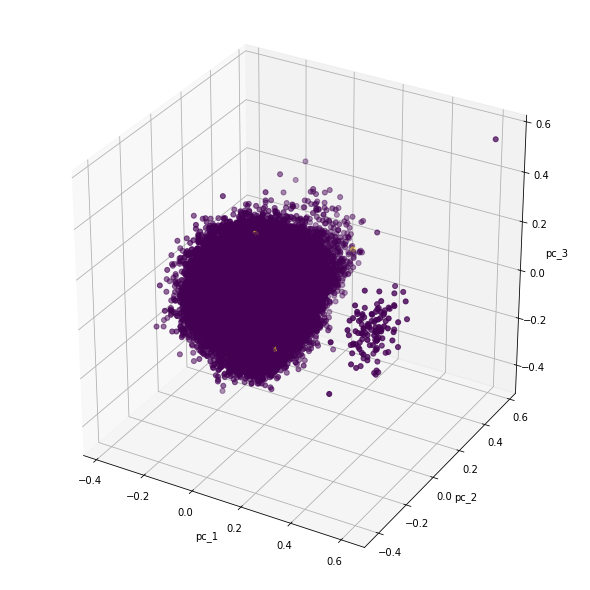

In [10]:
show_pca_df(df)

### Subsampling

In [11]:
#Split fraud and normal transactions
fraud_data = df[df['Class']==1]
non_fraud_data = df[df["Class"]==0]

#Subsample according to the size of fraud transactions
non_fraud_data1 = non_fraud_data.sample(1500)

#Rejoin fraud and normal transactions
final_data = fraud_data.append(non_fraud_data1,ignore_index=True)


In [12]:
print('No Frauds', round(final_data['Class'].value_counts()[0]/len(final_data) * 100,2), '% of the dataset')
print('Frauds', round(final_data['Class'].value_counts()[1]/len(final_data) * 100,2), '% of the dataset')

No Frauds 75.3 % of the dataset
Frauds 24.7 % of the dataset


Distribution of the Classes in the subsample dataset
0    0.753012
1    0.246988
Name: Class, dtype: float64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


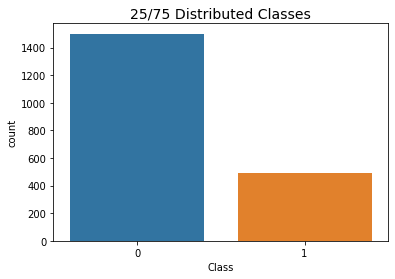

In [13]:
print('Distribution of the Classes in the subsample dataset')
print(final_data['Class'].value_counts()/len(final_data))

sns.countplot('Class', data=final_data)
plt.title('25/75 Distributed Classes', fontsize=14)
plt.show()

In [14]:
final_data['Class'].value_counts()

0    1500
1     492
Name: Class, dtype: int64

[0.20577961 0.14728955 0.09800457]


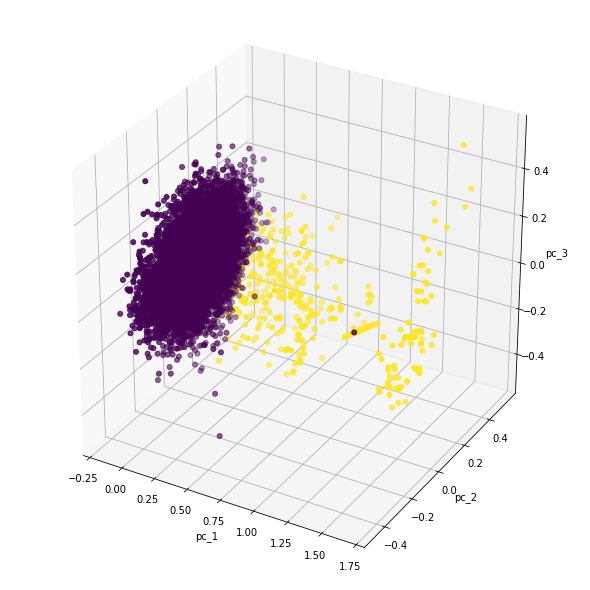

In [15]:
fraud = df[df[df.columns[30]] > 0]
non_fraud = df[df[df.columns[30]] == 0].sample(n=fraud.size, random_state=1, axis='index')
df = pd.concat([ fraud, non_fraud])

show_pca_df(df)

## Normalize Data

In [16]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df['Time'] = StandardScaler().fit_transform(df['Time'].values.reshape(-1, 1))

## Splitting Data

In [17]:
anomalies = df[df["Class"] == 1]
normal = df[df["Class"] == 0]

data_set = pd.concat([normal[:1500], anomalies])

x_train, x_test = train_test_split(data_set, test_size = 0.2)

x_train = x_train.sort_values(by=['Time'])
x_test = x_test.sort_values(by=['Time'])

y_train = x_train["Class"]
y_test = x_test["Class"]

x_train = x_train.drop("Class",axis=1)
x_test = x_test.drop("Class",axis=1)

x_test.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
229,-1.979329,-0.903628,-0.233363,2.580864,-0.990572,-0.397920,0.281755,0.238619,0.249102,0.651330,-0.881775,0.939972,0.397779,-1.494563,-0.428434,-1.307942,-0.095618,-0.080170,-0.432193,-0.336658,0.050471,-0.075017,-0.097906,0.059448,0.244548,-0.316141,0.754405,-0.166316,-0.138177,-0.082732
2831,-1.932057,-0.518394,1.108301,1.163560,-0.148488,0.490939,-0.314171,0.792125,-0.106798,0.000491,-0.026223,-0.236882,-0.313890,-0.091448,-0.656768,1.244535,0.102987,0.055869,-0.485115,-0.335946,0.273204,-0.346534,-0.653056,-0.029312,-0.347864,-0.161376,0.101977,0.206212,-0.073040,-0.353321
3649,-1.917075,1.248387,-0.091206,0.303811,-0.104753,-0.526679,-0.707099,-0.163463,-0.041177,0.399964,-0.206574,-0.169019,-0.240756,-0.925812,0.465589,1.499286,0.011357,0.032397,-0.822384,-0.281581,-0.158507,-0.091895,-0.269220,0.084743,0.119461,0.132489,0.992821,-0.074608,-0.001264,-0.344954
4922,-1.888792,-0.155718,-0.555641,1.848151,-1.109779,-1.400660,-0.251651,-0.363722,-0.168415,-0.829275,0.573435,0.063423,-3.152961,2.617969,0.568136,-1.187621,-1.125796,1.776016,0.073773,0.779427,-0.008190,-0.480731,-0.747545,0.350116,0.241410,-0.693711,-0.472586,0.157351,0.172324,0.030459
4977,-1.887281,-1.400193,0.744386,2.118092,3.126864,-1.401758,1.460903,0.375688,0.706134,-0.032459,-0.031022,1.358014,-2.305601,1.751484,1.643707,-0.481714,0.476969,0.606288,1.483834,0.892238,0.791609,0.209277,0.424350,0.388423,-0.072557,0.282644,0.366931,0.111733,0.099355,0.811212
5641,-1.859669,1.012633,0.185475,1.857025,2.625659,-0.813666,0.741190,-1.050536,0.411454,1.078232,0.410754,2.237912,-2.310506,0.771148,1.647483,0.005916,1.168254,-0.044723,0.838385,-1.766318,-0.240510,0.167710,0.665263,0.034245,0.149376,0.061459,0.073727,0.024627,0.023361,-0.320538
5932,-1.845191,-0.448185,0.987939,1.800664,1.039269,0.107695,-0.425207,0.578578,-0.086358,0.319713,-0.499242,2.403731,-1.659643,1.967790,1.858422,-0.348536,-0.109896,0.309484,0.765043,0.449594,0.084419,0.005555,0.191573,-0.027589,0.480824,-0.294946,-0.487604,0.120259,0.141266,-0.228626
6004,-1.841163,1.041129,-0.136980,1.611763,1.266538,-1.047898,0.374092,-1.089656,0.365252,1.939952,-0.271491,2.315360,-2.250095,0.274533,1.794196,0.524404,0.641067,0.156434,1.032053,-1.128070,-0.245933,0.184673,0.748325,-0.009773,0.132448,0.163238,-0.288829,0.051591,0.024520,-0.288962
6108,-1.835959,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,-0.132047
6566,-1.815439,-1.175765,1.038493,1.331686,-0.461610,0.289981,-0.360334,0.293541,0.613002,0.745002,-1.382102,1.690985,-2.474468,-0.250246,2.445880,-1.291850,0.792981,-0.095394,0.379293,-2.211593,-0.536409,0.011623,-0.083085,-0.081805,-0.120049,-0.086699,-0.812416,-0.059887,0.021954,-0.329146


In [18]:
input_shape = (x_train.shape[1], 1)


print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(1593, 30)
y_train:(1593,)

x_test:(399, 30)
y_test:(399,)

input_shape:(30, 1)



In [19]:
x_train[:5]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
196,-1.979811,-0.485238,0.658497,1.949967,1.249695,0.426410,0.231513,0.585115,0.029163,-0.520297,0.055911,1.265311,0.521277,-0.830439,0.157455,-0.365075,-1.142187,0.409601,-0.204876,1.010483,0.089378,0.007290,0.328244,-0.232563,0.225572,0.025892,-0.247395,-0.025381,-0.118565,-0.345356
258,-1.978741,1.136752,-0.103770,0.904686,0.488211,-0.678524,0.039861,-0.581294,0.270996,0.256540,0.068092,1.445184,0.506268,-0.850215,0.464223,0.963247,0.522012,-0.463008,0.029022,-0.386661,-0.166087,-0.017527,-0.093159,0.119723,-0.000588,0.026252,0.229223,0.000201,0.010945,-0.343345
482,-1.975090,0.019256,0.471698,0.868060,-1.239124,0.547898,-0.502661,0.808516,-0.247667,0.130741,-0.484994,-0.702094,-0.213445,-0.048713,-0.065307,0.658810,0.168526,-0.621304,-0.690750,-0.697036,-0.107130,0.021430,0.265057,0.066608,-0.381752,-1.305171,0.646049,-0.013625,-0.011985,-0.358872
541,-1.974020,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,-0.369370
615,-1.972824,-0.634597,0.866354,1.123836,-0.304041,1.173910,0.257118,0.754325,0.171735,-0.825981,-0.531058,0.549389,0.598609,0.313814,0.354548,-0.156778,0.328551,-0.983933,0.235906,-0.630728,-0.105239,0.160463,0.422873,-0.353721,-0.847192,0.206896,-0.436112,0.110134,0.102261,-0.365348


In [20]:
def plot_learning_curve(history,epochs):
    epoch_range=range(1,epochs+1)
    plt.plot(epoch_range,history.history['accuracy'])
    plt.plot(epoch_range,history.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend("train","val",loc="upper left")
    plt.show()
     
    plt.plot(epoch_range,history.history['loss'])
    plt.plot(epoch_range,history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train','Val'],loc='upper left')
    plt.show()

## Deep Neural Network

In [21]:
DNN = Sequential([
Dense(input_dim = 30, units = 16, activation = 'relu'),
Dense(units = 24, activation = 'relu'),
Dense(units = 20, activation = 'relu'),
Dense(units = 24, activation = 'relu'),
Dense(units =1, activation = 'sigmoid'),])

In [22]:
DNN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
history = DNN.fit(x_train, y_train, epochs = 50, validation_data = (x_test,y_test),verbose=1)

Epoch 1/50
50/50 [==============================] - 1s 13ms/step - loss: 0.5885 - accuracy: 0.8429 - val_loss: 0.3750 - val_accuracy: 0.9373
Epoch 2/50
50/50 [==============================] - 0s 3ms/step - loss: 0.2845 - accuracy: 0.9577 - val_loss: 0.1945 - val_accuracy: 0.9474
Epoch 3/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1768 - accuracy: 0.9548 - val_loss: 0.1557 - val_accuracy: 0.9524
Epoch 4/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1123 - accuracy: 0.9659 - val_loss: 0.1457 - val_accuracy: 0.9524
Epoch 5/50
50/50 [==============================] - 0s 3ms/step - loss: 0.0905 - accuracy: 0.9739 - val_loss: 0.1434 - val_accuracy: 0.9499
Epoch 6/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1014 - accuracy: 0.9663 - val_loss: 0.1439 - val_accuracy: 0.9499
Epoch 7/50
50/50 [==============================] - 0s 3ms/step - loss: 0.1004 - accuracy: 0.9655 - val_loss: 0.1433 - val_accuracy: 0.9524
Epoch 8/50
50/50 [=

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  


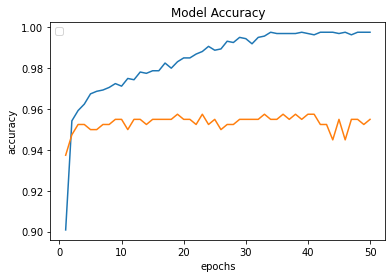

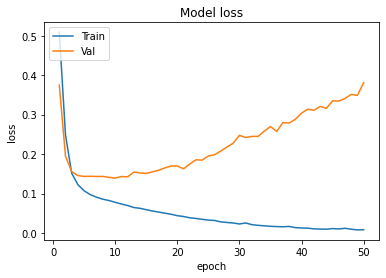

In [23]:
plot_learning_curve(history, 50)

In [24]:
score = DNN.evaluate(x_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.3812 - accuracy: 0.9549


In [25]:
y_pred = DNN.predict(x_test)
cm = confusion_matrix(y_test, y_pred.round())

In [26]:
print(classification_report(y_test, y_pred.round()))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       300
           1       0.96      0.86      0.90        99

    accuracy                           0.95       399
   macro avg       0.95      0.92      0.94       399
weighted avg       0.95      0.95      0.95       399



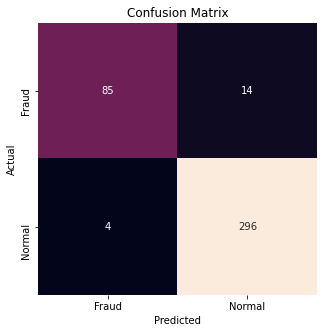

In [27]:
labels = ["Fraud", "Normal"]

matrix = np.flip(cm)

plt.figure(figsize=(5, 5))
sns.heatmap(matrix, xticklabels=labels, yticklabels=labels,  annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Convolutional Neural Network

In [28]:
x_train = np.array(x_train).reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = np.array(x_test).reshape(x_test.shape[0], x_test.shape[1], 1)
input_shape = (x_train.shape[1], 1)

print("Shapes:\nx_train:%s\ny_train:%s\n" % (x_train.shape, y_train.shape))
print("x_test:%s\ny_test:%s\n" % (x_test.shape, y_test.shape))
print("input_shape:{}\n".format(input_shape))

Shapes:
x_train:(1593, 30, 1)
y_train:(1593,)

x_test:(399, 30, 1)
y_test:(399,)

input_shape:(30, 1)



In [29]:
x_train[:5]

array([[[-1.97981139e+00],
        [-4.85237731e-01],
        [ 6.58496594e-01],
        [ 1.94996662e+00],
        [ 1.24969475e+00],
        [ 4.26410290e-01],
        [ 2.31512687e-01],
        [ 5.85115384e-01],
        [ 2.91629910e-02],
        [-5.20297446e-01],
        [ 5.59114747e-02],
        [ 1.26531109e+00],
        [ 5.21276565e-01],
        [-8.30439424e-01],
        [ 1.57454834e-01],
        [-3.65074566e-01],
        [-1.14218704e+00],
        [ 4.09601003e-01],
        [-2.04876492e-01],
        [ 1.01048316e+00],
        [ 8.93777272e-02],
        [ 7.29012156e-03],
        [ 3.28243726e-01],
        [-2.32563155e-01],
        [ 2.25572061e-01],
        [ 2.58916791e-02],
        [-2.47395420e-01],
        [-2.53810208e-02],
        [-1.18564650e-01],
        [-3.45356468e-01]],

       [[-1.97874131e+00],
        [ 1.13675205e+00],
        [-1.03769567e-01],
        [ 9.04686444e-01],
        [ 4.88210755e-01],
        [-6.78523515e-01],
        [ 3.98607288e-02],

In [30]:
CNN=Sequential()

CNN.add(Conv1D(filters=32, kernel_size=2, activation='relu', padding='causal',input_shape=x_train[0].shape))
CNN.add(BatchNormalization())
CNN.add(MaxPool1D(pool_size=2))
CNN.add(Dropout(rate=0.2))

CNN.add(Conv1D(64,2, padding='causal',activation='relu'))
CNN.add(BatchNormalization())
CNN.add(MaxPool1D(pool_size=2))
CNN.add(Dropout(rate=0.5))


#flattening layer
CNN.add(Flatten())
CNN.add(Dense(64,activation="relu"))
CNN.add(Dropout(rate=0.5))

#final layer
CNN.add(Dense(units=1,activation="sigmoid"))

In [31]:
CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 30, 32)            96        
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 15, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 64)            

In [32]:
CNN.compile(optimizer=Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history =CNN.fit(x_train,y_train,epochs=50, validation_data = (x_test,y_test),verbose=1)

Epoch 1/50
50/50 [==============================] - 2s 12ms/step - loss: 0.5601 - accuracy: 0.7861 - val_loss: 0.3562 - val_accuracy: 0.9348
Epoch 2/50
50/50 [==============================] - 0s 7ms/step - loss: 0.2443 - accuracy: 0.9338 - val_loss: 0.2321 - val_accuracy: 0.9474
Epoch 3/50
50/50 [==============================] - 0s 7ms/step - loss: 0.2179 - accuracy: 0.9453 - val_loss: 0.1828 - val_accuracy: 0.9524
Epoch 4/50
50/50 [==============================] - 0s 7ms/step - loss: 0.1830 - accuracy: 0.9441 - val_loss: 0.1630 - val_accuracy: 0.9524
Epoch 5/50
50/50 [==============================] - 0s 7ms/step - loss: 0.1755 - accuracy: 0.9453 - val_loss: 0.1498 - val_accuracy: 0.9524
Epoch 6/50
50/50 [==============================] - 0s 7ms/step - loss: 0.1885 - accuracy: 0.9457 - val_loss: 0.1472 - val_accuracy: 0.9524
Epoch 7/50
50/50 [==============================] - 0s 7ms/step - loss: 0.1548 - accuracy: 0.9508 - val_loss: 0.1431 - val_accuracy: 0.9499
Epoch 8/50
50/50 [=

In [ ]:
plot_learning_curve(history, 50)

In [ ]:
final_acc = CNN.evaluate(x_train,y_train, verbose=0)
print('Test loss:', final_acc[0])
print('Test accuracy:', final_acc[1])

In [ ]:
print(classification_report(y_test, y_pred.round()))

In [ ]:
y_pred = CNN.predict(x_test)
cm = confusion_matrix(y_test, y_pred.round())

In [ ]:
print(classification_report(y_test, y_pred.round()))

In [ ]:
labels = ["Fraud", "Normal"]

matrix = np.flip(cm)

plt.figure(figsize=(5, 5))
sns.heatmap(matrix, xticklabels=labels, yticklabels=labels,  annot=True, fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()